In [1]:
# Installera Pytorch i cmd: pip install torch torchvision torchaudio

In [2]:
# Importera libraries
import numpy as np
import matplotlib.pyplot as plt

#importera data sets
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image

In [3]:
# förberedelse av data i form av normalisering av bilder samt omvandling till tensor

# Dataklass för hantering av CIFAR-10 datasetet:
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, dataset_path='dataset/'):
        self.rawdata = datasets.CIFAR10(root=dataset_path, train=train, download=True)
        self.mean, self.std = 0.5, 0.5 # Normaliseringsvären
        self.train = train

# Augmentationer för träningsdata 
        if self.train:
            self.augment = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.RandomCrop(32, padding=4)
            ])
        else:
            self.augment = None
        
    
#Normalisering och omvandling av bilder till tensorformat
    def preprocess_image(self, image):
        image = Image.fromarray(np.array(image, dtype=np.uint8)) #Omvandlar bild
        if self.train and self.augment:
            image = self.augment(image) # Apllicerar tränings augmentationen
        image = np.array(image, dtype=np.float32) / 255.0 #Skalning
        image = (image - self.mean) / self.std # Normaliserar
        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) # Omformaterar till tensor
  
    def __getitem__(self, index):
        image, label = self.rawdata[index]
        return self.preprocess_image(image), label

        if self.train and self.augment:
            image = self.augment(image)

        image = self.preprocess_image(image)
        return image, label

    def __len__(self):
        return len(self.rawdata)
    

        

In [4]:
#Dataloader som laddar data i batcher och slumpar ordning

from random import shuffle

class DataloaderRandom:
    def __init__(self, dataset, batch_size=64, shuffle_data=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        if shuffle_data:
            shuffle(self.indices)

    def __iter__(self):
        batch = []
        for idx in self.indices:
            batch.append(self.dataset[idx])
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if batch:
            yield batch # Återför sista batchen om den inte är full

    def __len__(self):
        return(len(self.dataset) + self.batch_size -1) // self.batch_size #Antal batchar
      

In [5]:
# Definera labels för klasserna 
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# Skapa dataset och dataloaders
from torch.utils.data import random_split

# Skapar dataset
training_dataset = CustomCIFAR10Dataset(train=True)
testing_dataset = CustomCIFAR10Dataset(train=False)

training_size = int(0.8 * len(training_dataset))
validation_size = len(training_dataset) - training_size
training_data, validation_data = random_split(training_dataset, [training_size, validation_size])

# Skapar dataloaders
training_loader = DataloaderRandom(training_dataset, batch_size=32, shuffle_data=True)
testing_loader = DataloaderRandom(testing_dataset, batch_size=32, shuffle_data=False)
validation_loader = DataloaderRandom(validation_data, batch_size=32, shuffle_data=False)

print(f"Träningsdata: {len(training_data)}, Valideringsdata: {len(validation_data)}, Testdata: {len(testing_dataset)}")

Träningsdata: 40000, Valideringsdata: 10000, Testdata: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.69411767].


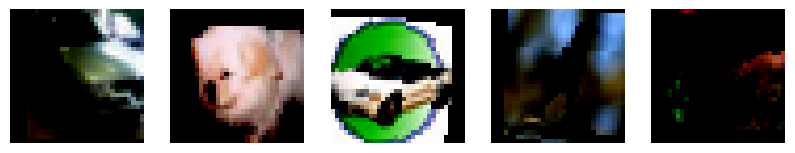

In [7]:
# Funktion för visualisering av bilder 

#Visar antal bilder i dataloader:
def display_image(dataloader, num_images=5):
    batch = next(iter(dataloader))
    images, labels = zip(*batch[:num_images])
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, img in enumerate(images):
        axes[i].imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show

#Visar exempelbilder från dataset
display_image(training_loader)

In [8]:
# Skapa Neuralnetwork och definera det för bildklassificering

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
# CNN med två konolutionslagar och 3 fullt anslutna lager

class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 15, kernel_size=5, stride=1, padding=2) #definerar arktitekturen (3 input kanaler,16 feauture maps, kernel med 5x5)
        self.conv2 = nn.Conv2d(15, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2,2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.5) 

# Definerar framåtriktad sprigning i nätverket
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    

In [15]:
# Skpar nätverksinstans och definition av förlustfunktion och optimizer
net = ImageClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

In [20]:
# Tillämpar träningsfas följt av en valideringsfas i varje epok 

# Early stop-variabel
best_validation_loss = float('inf')
patience = 5 # Antal epoker som får gå innan vi stoppar om validation_loss inte förbättras
counter = 0

epochs = 30
for epoch in range(epochs):
    print(f'Training Epoch {epoch}...')

    # Sätter modellen i träningsläge
    net.train()
    total_training_loss = 0.0

    for batch in training_loader:
        inputs, labels = zip(*batch)
        inputs = torch.stack(inputs)
        labels = torch.tensor(labels)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_training_loss += loss.item()

    avg_training_loss = total_training_loss / len(training_loader)

    #Sätter modellen i valideringsläge
    net.eval()
    total_validation_loss = 0.0

    with torch.no_grad():
        for batch in validation_loader:
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs)
            labels = torch.tensor(labels)

            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            total_validation_loss += loss.item()
            
    avg_validation_loss = total_validation_loss / len(validation_loader)
    print(f'Loss: Train {avg_training_loss:.4f}, Validation {avg_validation_loss:.4f}')

    # Early stopping
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        counter = 0
        torch.save(net.state_dict(), 'best_model.pth') #sparar bästa modellen
        print("Model saved(validation loss improved)")
    else:
        counter += 1
        print(f"No improvment ({counter}/{patience})")

        if counter >= patience:
            print("Early stopping! Training stopped.")
            break #avbrott av träningsloop
            

Training Epoch 0...
Loss: Train 1.2627, Validation 1.1595
Model saved(validation loss improved)
Training Epoch 1...
Loss: Train 1.2510, Validation 1.1387
Model saved(validation loss improved)
Training Epoch 2...
Loss: Train 1.2541, Validation 1.1206
Model saved(validation loss improved)
Training Epoch 3...
Loss: Train 1.2409, Validation 1.1390
No improvment (1/5)
Training Epoch 4...
Loss: Train 1.2328, Validation 1.1066
Model saved(validation loss improved)
Training Epoch 5...
Loss: Train 1.2213, Validation 1.0815
Model saved(validation loss improved)
Training Epoch 6...
Loss: Train 1.2162, Validation 1.0671
Model saved(validation loss improved)
Training Epoch 7...
Loss: Train 1.2069, Validation 1.0573
Model saved(validation loss improved)
Training Epoch 8...
Loss: Train 1.1963, Validation 1.0506
Model saved(validation loss improved)
Training Epoch 9...
Loss: Train 1.1908, Validation 1.0656
No improvment (1/5)
Training Epoch 10...
Loss: Train 1.1899, Validation 1.0573
No improvment (2/

In [21]:
torch.save(net.state_dict(), 'best_model.pth') # Spara bästa modellen
net.load_state_dict(torch.load('best_model.pth')) # Ladda den bästa modellen
net.eval()

ImageClassifier(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(15, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
# Utvärdering av testdatan 
correct, total = 0, 0
net.eval()

with torch.no_grad():
    for batch in testing_loader:
        inputs, labels = zip(*batch)
        inputs = torch.stack(inputs)
        labels = torch.tensor(labels)
    
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Model Accuracy: {accuracy:.2f}%')

# Test av modellen på enstaka bilder

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((32, 32)) #Ändrar storlek på bilder till 32x32
    image = transforms.ToTensor()(image) #Omvandlar till tensor
    image = (image - 0.5) / 0.5 #M Nomalisering
    image = image.unsqueeze(0) # Lägger till batch-dimension
    return image

image_paths = ['testbild1.jpg', 'testbild2.webp']
images = [load_image(img) for img in image_paths]

net.eval()
with torch.no_grad():
    for image, path in zip(images, image_paths):
        output = net(image)
        __, predicted = torch.max(output, 1)
        print(f'Prediction for {path}: {classes[predicted.item()]}')
    
    

Model Accuracy: 68.79%
Prediction for testbild1.jpg: bird
Prediction for testbild2.webp: car
